In [1]:
!pip install GetOldTweets3
!pip install textblob
import GetOldTweets3 as got

import nltk
import pickle
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from textblob import TextBlob 
from string import punctuation 


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from newspaper import Article

import pandas as pd
import preprocessor as p
import numpy as np
import datetime

In [2]:
#get text from urls in the tweet
def get_url_text(urls):
    tweet_text = ''
    for url in urls:
        article = Article(url.match)
        tweet_text= tweet_text+' '+article.text
    
    return tweet_text

In [3]:
#clean tweets

# loading stopwords
stop = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])

def clean_tweets(tweet_text):

    #tweet  = tweet_text.lower() # convert text to lower-case
    #tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
    #tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
    #tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
    
    #get text from the URLs
    parsed_tweet = p.parse(tweet_text)
    
    if parsed_tweet.urls is not None and len(parsed_tweet.urls) !=0:
        tweet_text = tweet_text +' '+get_url_text(parsed_tweet.urls)
    
    tweet = p.clean(tweet_text)
    tweet = re.sub('[^A-Za-z0-9 ]+', '', tweet) #remove special characters
    tweet = word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
    arr = [i for i in tweet if i not in stop]
    return ' '.join(arr)
    
   


# replace words with hypernyms
'''def hypernym_replace(tweet_text):
    arr = []
    for word in tweet_text.split():
        # check if word exists in wordnet
        if wn.synsets(word) != []:
            # check if word has hypernyms
            if wn.synsets(word)[0].hypernyms() != []:
                arr.append(wn.synsets(word)[0].hypernyms()[0]._name)
    array = " ".join(arr)
    return array

def remove_periods(df):
    arr = []
    for word in df.split():
        the_real = word.split('.', 1)[0]
        arr.append(the_real)
    return " ".join(arr)'''

'def hypernym_replace(tweet_text):\n    arr = []\n    for word in tweet_text.split():\n        # check if word exists in wordnet\n        if wn.synsets(word) != []:\n            # check if word has hypernyms\n            if wn.synsets(word)[0].hypernyms() != []:\n                arr.append(wn.synsets(word)[0].hypernyms()[0]._name)\n    array = " ".join(arr)\n    return array\n\ndef remove_periods(df):\n    arr = []\n    for word in df.split():\n        the_real = word.split(\'.\', 1)[0]\n        arr.append(the_real)\n    return " ".join(arr)'

In [4]:
#get tweets
def get_tweets(user,query,fromDate,toDate):
    
    ''' 
    Main function to fetch tweets and parse them. 
    '''
    # empty list to store parsed tweets 
    #tweets = [] 
    tweets_df = pd.DataFrame(columns=['date', 'text'])    
    tweetCriteria = got.manager.TweetCriteria().setUsername(user)\
                                            .setQuerySearch(query)\
                                            .setSince(fromDate)\
                                           .setUntil(toDate)\
    
    try:
        fetched_tweets = got.manager.TweetManager.getTweets(tweetCriteria)

        # parsing tweets one by one 
        for tweet in fetched_tweets: 
            if not tweets_df[tweets_df['date'] == tweet.date.date()].empty:
                text = tweet.text
                #tweets_df[tweets_df['date'] == tweet.date.date()]['text']+=text
                tweets_df.loc[tweets_df['date'] == tweet.date.date(),['text']]=tweets_df.loc[tweets_df['date'] == tweet.date.date(),['text']]+'\n'+text
            else:
                #print(tweet.date.date(),tweet.text)
                tweets_df = tweets_df.append({'date': tweet.date.date(), 'text': tweet.text}, ignore_index=True)
            #print(tweets_df.head())
        return tweets_df
    except (AttributeError,NameError) as e:
        print("Not able to process the tweet"+ str(e))
    

In [5]:

def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        #elif analysis.sentiment.polarity == 0: 
            #return 'neutral'
        else: 
            return 'negative'

In [6]:
#Main Function

user='BBCPolitics'
query='brexit'
fromDate="2019-02-01"
toDate="2019-08-01"

bbc_tweets_df = get_tweets(user,query,fromDate,toDate)
bbc_tweets_df.head()

bbc_tweets_df['text'] = bbc_tweets_df['text'].apply(clean_tweets)
#bbc_tweets_df['text'] = bbc_tweets_df['text'].apply(hypernym_replace)
#bbc_tweets_df['text'] = bbc_tweets_df['text'].apply(remove_periods)
bbc_tweets_df['political_sentiment'] = bbc_tweets_df['text'].apply(get_tweet_sentiment)
bbc_tweets_df.head()




,date,text,political_sentiment
0,2019-07-31,No room excess meat nodeal Brexit Brexit How U...,positive
1,2019-07-30,Were aiming nodeal dont think thats well end s...,positive
2,2019-07-29,Brexit Dont underestimate Boris Johnson EU war...,positive
3,2019-07-28,Its really important businesses get geared New...,positive
4,2019-07-27,Weve got get ready I dont think well end PM Bo...,positive


In [7]:
print(bbc_tweets_df['text'][10])

Prisons minister Boris Johnson supporter Robert Buckland says st October deadline must worked Did permission abstain Philip Hammond No The chancellor says defied whip abstaining vote week despite permission Irish Deputy Prime Minister Simon Coveney deal If new British prime minister chooses take Britain direction happen This British choice We deal Im going resign The chancellor Philip Hammond tells going hand resignation Theresa May week Simon Coveney GATT We dont think thats viable option Thats nonstarter Irelands deputy prime minister GATT plan put forward Boris Johnson Conservative leadership race Irelands Deputy Prime Minister Simon Coveney tells trouble next prime minister wants tear withdrawal agreement Brexit Irish deputy PM hopes backstop unnecessary


In [8]:
user='FXstreetNews'
query='GBP/USD'
fromDate="2019-02-01"
toDate="2019-08-01"

fxstreet_tweets_df = get_tweets(user,query,fromDate,toDate)
fxstreet_tweets_df.head()

fxstreet_tweets_df['text'] = fxstreet_tweets_df['text'].apply(clean_tweets)
#fxstreet_tweets_df['text'] = fxstreet_tweets_df['text'].apply(hypernym_replace)
#fxstreet_tweets_df['text'] = fxstreet_tweets_df['text'].apply(remove_periods)

fxstreet_tweets_df['financial_sentiment'] = fxstreet_tweets_df['text'].apply(get_tweet_sentiment)
fxstreet_tweets_df.head()

,date,text,financial_sentiment
0,2019-07-31,GBPUSD technical analysis HMA limits immediate...,positive
1,2019-07-30,USD skidding along bottom recent selloffs bear...,negative
2,2019-07-29,GBPUSD bears ready pounce hawkish Fed cut 1 ha...,negative
3,2019-07-28,GBPUSD remains back foot around multiyear low ...,positive
4,2019-07-27,GBPUSD Eerts neutral short term bullish afterward,negative


In [9]:
#Join Data from BBC and FX news
final_data_df = pd.merge(bbc_tweets_df,fxstreet_tweets_df,on='date')
final_data_df['date'] = final_data_df['date'].apply(str)
final_data_df.head()

,date,text_x,political_sentiment,text_y,financial_sentiment
0,2019-07-31,No room excess meat nodeal Brexit Brexit How U...,positive,GBPUSD technical analysis HMA limits immediate...,positive
1,2019-07-30,Were aiming nodeal dont think thats well end s...,positive,USD skidding along bottom recent selloffs bear...,negative
2,2019-07-29,Brexit Dont underestimate Boris Johnson EU war...,positive,GBPUSD bears ready pounce hawkish Fed cut 1 ha...,negative
3,2019-07-28,Its really important businesses get geared New...,positive,GBPUSD remains back foot around multiyear low ...,positive
4,2019-07-27,Weve got get ready I dont think well end PM Bo...,positive,GBPUSD Eerts neutral short term bullish afterward,negative


In [10]:
final_data_df.financial_sentiment.value_counts()



positive    95
negative    63
Name: financial_sentiment, dtype: int64

In [11]:
X = final_data_df.iloc[:, 1].values
y = final_data_df.iloc[:, 4].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords.words('english'))),
    ('clf', OneVsRestClassifier(SVC(kernel='rbf')))
])
parameters = {
    'tfidf__max_features': (500,1000,2500,3000,3500,4000,4500,5000,6000),
    'tfidf__min_df': (2,3,4,5,6),
    'tfidf__max_df': (0.4,0.5,0.6,0.7,0.8,0.9),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]
    #'clf__estimator__alpha': (1e-2, 1e-3)
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=3, n_jobs=2, verbose=3)
grid_search_tune.fit(X_train, y_train)

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  32 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 224 tasks      | elapsed:   10.9s
[Parallel(n_jobs=2)]: Done 544 tasks      | elapsed:   24.0s
[Parallel(n_jobs=2)]: Done 992 tasks      | elapsed:   42.5s
[Parallel(n_jobs=2)]: Done 1568 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 2272 tasks      | elapsed:  1.6min


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.4, max_features=500,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)), ('clf', OneVsRestClassifier(estimator=SVC(C=1

[Parallel(n_jobs=2)]: Done 2430 out of 2430 | elapsed:  1.7min finished
/Users/deepashree/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [12]:
features = final_data_df.iloc[:, 1].values
labels = final_data_df.iloc[:, 4].values


vectorizer = TfidfVectorizer (analyzer='word', binary=False, decode_error='strict', encoding='utf-8',
                input='content', lowercase=True,max_features=4000, min_df=5, max_df=0.8, ngram_range=(1, 1),
                              norm='l2', preprocessor=None,smooth_idf=True,stop_words=stopwords.words('english'),
                             strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)
features = vectorizer.fit_transform(features).toarray()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=5)

smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)



In [13]:
scores = []
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
cv = KFold(n_splits=6, random_state=42, shuffle=False)
for train_index, test_index in cv.split(features):
    #print("Train Index: ", train_index, "\n")
    #print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = features[train_index], features[test_index], labels[train_index], labels[test_index]
    text_classifier.fit(X_train, y_train)
    scores.append(text_classifier.score(X_test, y_test))
print(np.mean(scores))

0.5137701804368471


In [14]:
scores = []
best_svr = SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto_deprecated',
                                  kernel='rbf', max_iter=-1, probability=False,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False)
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(features):
    #print("Train Index: ", train_index, "\n")
    #print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = features[train_index], features[test_index], labels[train_index], labels[test_index]
    best_svr.fit(X_train, y_train)
    scores.append(best_svr.score(X_test, y_test))
print(np.mean(scores))

0.6020161290322581


/Users/deepashree/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/deepashree/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/deepashree/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/deepashree/anaconda3/lib/python3.

In [15]:
scores = []
naive_bayes = MultinomialNB()
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(features):
    #print("Train Index: ", train_index, "\n")
    #print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = features[train_index], features[test_index], labels[train_index], labels[test_index]
    naive_bayes.fit(X_train, y_train)
    scores.append(naive_bayes.score(X_test, y_test))
print(np.mean(scores))

0.602016129032258


In [16]:
#read currency exchange rate data
fx_rate_df = pd.read_excel("exchangerates.xlsx",index=False)
fx_rate_df['Date'] = fx_rate_df['Date'].apply(str)
fx_rate_df['Date'] = fx_rate_df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%A %d %B %Y').strftime('%Y-%m-%d'))

del fx_rate_df['Refernce Price']
del fx_rate_df['Percentage']
#del fx_rate_df['First']
del fx_rate_df['Last']
fx_rate_df.head()

,Date,Min,Average,Max,First
0,2019-07-31,1.213857,1.217420,1.224627,1.215053
1,2019-07-30,1.212010,1.217189,1.222647,1.221749
2,2019-07-29,1.221452,1.231082,1.238328,1.237984
3,2019-07-28,1.237502,1.238104,1.238506,1.238106
4,2019-07-27,1.238106,1.238106,1.238240,1.238106


In [17]:
#format date as per the sentiment analysis data
#fx_rate_df['date'] = fx_rate_df['date'].apply(str)
#fx_rate_df.date = fx_rate_df['date'].str[:4]+'-'+fx_rate_df['date'].str[4:6]+'-'+fx_rate_df['date'].str[6:]


fx_rate_df.columns=['date','min','average','max','open']
fx_rate_df.sort_values(by ='date' )
fx_rate_df.head()

,date,min,average,max,open
0,2019-07-31,1.213857,1.217420,1.224627,1.215053
1,2019-07-30,1.212010,1.217189,1.222647,1.221749
2,2019-07-29,1.221452,1.231082,1.238328,1.237984
3,2019-07-28,1.237502,1.238104,1.238506,1.238106
4,2019-07-27,1.238106,1.238106,1.238240,1.238106


In [18]:
## ARIMA MODEL FOR FORECASTING

import matplotlib as plot


#get date and average rate for arima
exchangeRates_Series = fx_rate_df[['date','average','min','max']]
exchangeRates_Series = exchangeRates_Series.sort_values(by ='date',ascending=True )
exchangeRates_Series.reset_index()
exchangeRates_Series.head()
exchangeRates_Series.plot(x='date',y='average',color='red')

Actual=1.217420, Predicted=1.268761
Actual=1.217189, Predicted=1.194443
Actual=1.231082, Predicted=1.221346
Actual=1.238104, Predicted=1.231554
Actual=1.238106, Predicted=1.236148
Actual=1.242488, Predicted=1.235613
Actual=1.247619, Predicted=1.242693
Actual=1.246474, Predicted=1.247389
Actual=1.245223, Predicted=1.244747
Actual=1.248802, Predicted=1.244644
Actual=1.250256, Predicted=1.249341
Actual=1.250151, Predicted=1.249459
Actual=1.252446, Predicted=1.249401
Actual=1.246910, Predicted=1.252528
Actual=1.241761, Predicted=1.244915
Actual=1.248438, Predicted=1.241260
Actual=1.254798, Predicted=1.250393
Actual=1.257208, Predicted=1.254423
Actual=1.257196, Predicted=1.256037
Actual=1.254430, Predicted=1.256317
Actual=1.253032, Predicted=1.253452
Actual=1.247815, Predicted=1.252904
Actual=1.248288, Predicted=1.246601
Actual=1.252126, Predicted=1.249014
Actual=1.252261, Predicted=1.252522
Actual=1.252198, Predicted=1.251147
Actual=1.255055, Predicted=1.251741
Actual=1.257976, Predicted=1

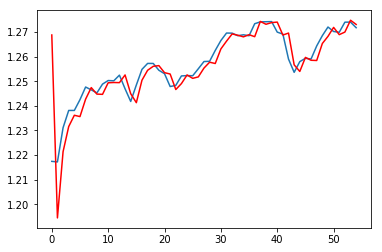

Test Mean Squared Error: 0.001
Test Mean Absolute Error: 0.021
Test Root Mean Squared Error: 0.021
Test Mean Absolute Percentage Error: 1.199


In [19]:
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
#from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction

#predict minimum exchange rate for the days

exchangeRates=exchangeRates_Series['average']
#Size of exchange rates
NumberOfElements = len(exchangeRates)

#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(NumberOfElements * 0.7)
TrainingData = exchangeRates[0:TrainingSize]
TestData = exchangeRates[TrainingSize:NumberOfElements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Predictions = list()


#in a for loop, predict values using ARIMA model
for timepoint in range(len(TestData)):
    ActualValue =  TestData[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 3,1,0)    
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    #add it in the list
    Predictions.append(Prediction)
    Actual.append(ActualValue)

# plot
pyplot.plot(TestData)
pyplot.plot(Predictions, color='red')
pyplot.show()

#Print MSE to see how good the model is
MSE = metrics.mean_squared_error(TestData, Predictions)
print('Test Mean Squared Error: %.3f' % MSE)

MAE = metrics.mean_absolute_error(TestData, Predictions)
print('Test Mean Absolute Error: %.3f' % MAE)

RMSE = metrics.mean_absolute_error(TestData, Predictions)
print('Test Root Mean Squared Error: %.3f' % RMSE)

TestData, Predictions = np.array(TestData), np.array(Predictions)
MAPE = np.mean(np.abs((TestData - Predictions) / TestData)) * 100
print('Test Mean Absolute Percentage Error: %.3f' % MAPE)





In [20]:
print(Predictions)

[[1.2687606 ]
 [1.19444266]
 [1.22134626]
 [1.23155442]
 [1.23614838]
 [1.235613  ]
 [1.24269349]
 [1.24738895]
 [1.24474689]
 [1.2446436 ]
 [1.24934078]
 [1.24945896]
 [1.24940074]
 [1.25252774]
 [1.24491542]
 [1.24125953]
 [1.25039309]
 [1.2544235 ]
 [1.25603737]
 [1.25631681]
 [1.25345244]
 [1.2529036 ]
 [1.24660123]
 [1.24901438]
 [1.25252224]
 [1.25114708]
 [1.25174118]
 [1.2553192 ]
 [1.2577045 ]
 [1.25717567]
 [1.26309312]
 [1.26625752]
 [1.26919052]
 [1.26865681]
 [1.2680037 ]
 [1.26887961]
 [1.26806867]
 [1.27427036]
 [1.27311446]
 [1.27379206]
 [1.27399966]
 [1.26874741]
 [1.26953875]
 [1.25663486]
 [1.25394629]
 [1.25965338]
 [1.25849308]
 [1.25840103]
 [1.26530269]
 [1.26820173]
 [1.27184481]
 [1.2689033 ]
 [1.26994773]
 [1.27475155]
 [1.27304499]]


In [21]:
#Merge financial sentiment analysis data and exchange rates

#sntmnt_rates_df = pd.merge(fx_rate_df,final_data_df,on='date')
sntmnt_rates_df = pd.merge(left=fx_rate_df,right=final_data_df, how='right',left_on='date', right_on='date')
sntmnt_rates_df = sntmnt_rates_df.sort_values(by ='date',ascending=True )
sntmnt_rates_df = sntmnt_rates_df[['financial_sentiment','average','open']]
sntmnt_rates_df = pd.get_dummies(sntmnt_rates_df)

sntmnt_rates_df.head()

,average,open,financial_sentiment_negative,financial_sentiment_positive
157,1.308713,1.310598,0,1
156,1.309097,1.309097,1,0
155,1.308947,1.309097,1,0
154,1.306475,1.307600,0,1
153,1.300341,1.304062,1,0


In [22]:
X = sntmnt_rates_df.iloc[:, 1:4].values
y = sntmnt_rates_df.iloc[:, 0].values

#Size of exchange rates
NumberOfElements = len(X)

#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(NumberOfElements * 0.7)
X_train = X[0:TrainingSize]
X_test = X[TrainingSize:NumberOfElements]

y_train = y[0:TrainingSize]
y_test = y[TrainingSize:NumberOfElements]


Test Mean Squared Error: 0.000
Test Mean Absolute Error: 0.002
Test Root Mean Squared Error: 0.002
Test Mean Absolute Percentage Error: 0.144


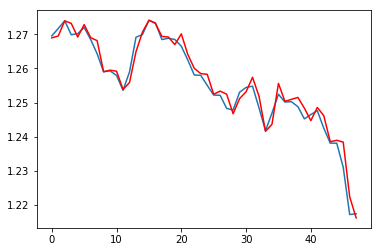

In [23]:
#Linear Regression
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

y_pred = regressor.predict(X_test)

#Print MSE to see how good the model is
MSE = metrics.mean_squared_error(y_test, y_pred)
print('Test Mean Squared Error: %.3f' % MSE)

MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Test Mean Absolute Error: %.3f' % MAE)

RMSE = metrics.mean_absolute_error(y_test, y_pred)
print('Test Root Mean Squared Error: %.3f' % RMSE)

MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Test Mean Absolute Percentage Error: %.3f' % MAPE)

# plot
pyplot.plot(y_test)
pyplot.plot(y_pred, color='red')
pyplot.show()

Test Mean Squared Error: 0.000
Test Mean Absolute Error: 0.002
Test Root Meanlasso = Lasso() Squared Error: 0.002
Test Mean Absolute Percentage Error: 0.193


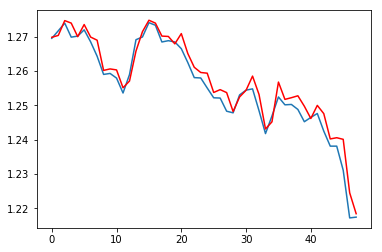

In [24]:
#Ridge Regression
rr = Ridge(alpha=0.001) # higher the alpha value, more restriction on the coefficients; 
#low alpha > more generalization, coefficients are barely  
rr.fit(X_train, y_train) #training the algorithm

y_pred = rr.predict(X_test)

#Print MSE to see how good the model is
MSE = metrics.mean_squared_error(y_test, y_pred)
print('Test Mean Squared Error: %.3f' % MSE)

MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Test Mean Absolute Error: %.3f' % MAE)

RMSE = metrics.mean_absolute_error(y_test, y_pred)
print('Test Root Meanlasso = Lasso() Squared Error: %.3f' % RMSE)

MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Test Mean Absolute Percentage Error: %.3f' % MAPE)

# plot
pyplot.plot(y_test)
pyplot.plot(y_pred, color='red')
pyplot.show()

Test Mean Squared Error: 0.000
Test Mean Absolute Error: 0.014
Test Root Mean Squared Error: 0.014
Test Mean Absolute Percentage Error: 1.139


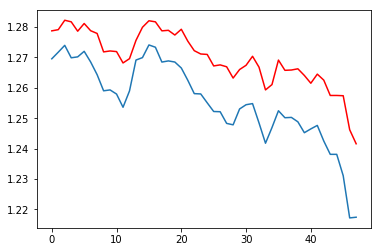

In [25]:
#Lasso Regression
lasso = Lasso(alpha=0.0001) 
lasso.fit(X_train, y_train) #training the algorithm

y_pred = lasso.predict(X_test)

#Print MSE to see how good the model is
MSE = metrics.mean_squared_error(y_test, y_pred)
print('Test Mean Squared Error: %.3f' % MSE)

MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Test Mean Absolute Error: %.3f' % MAE)

RMSE = metrics.mean_absolute_error(y_test, y_pred)
print('Test Root Mean Squared Error: %.3f' % RMSE)

MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Test Mean Absolute Percentage Error: %.3f' % MAPE)

# plot
pyplot.plot(y_test)
pyplot.plot(y_pred, color='red')
pyplot.show()

Test Mean Squared Error: 0.000
Test Mean Absolute Error: 0.015
Test Root Mean Squared Error: 0.015
Test Mean Absolute Percentage Error: 1.189


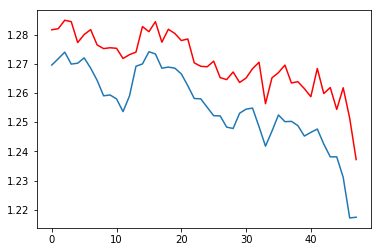

In [26]:
from sklearn.svm import SVR


svr = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma='auto',kernel='rbf', shrinking=True, tol=0.001, verbose=False)
svr.fit(X_train, y_train) #training the algorithm

y_pred = svr.predict(X_test)


#Print MSE to see how good the model is
MSE = metrics.mean_squared_error(y_test, y_pred)
print('Test Mean Squared Error: %.3f' % MSE)

MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Test Mean Absolute Error: %.3f' % MAE)

RMSE = metrics.mean_absolute_error(y_test, y_pred)
print('Test Root Mean Squared Error: %.3f' % RMSE)

MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Test Mean Absolute Percentage Error: %.3f' % MAPE)

# plot
pyplot.plot(y_test)
pyplot.plot(y_pred, color='red')
pyplot.show()

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 275
Trainable params: 275
Non-trainable params: 0
_________________________________________________________________
Train on 82 samples, validate on 36 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/150
82/82 [=

Epoch 22/150
82/82 [==============================] - 0s 169us/sample - loss: 0.2630 - mean_squared_error: 0.0991 - mean_absolute_error: 0.2630 - mean_absolute_percentage_error: 37.7923 - val_loss: 0.2653 - val_mean_squared_error: 0.0969 - val_mean_absolute_error: 0.2653 - val_mean_absolute_percentage_error: 554.0049
Epoch 23/150
82/82 [==============================] - 0s 176us/sample - loss: 0.2471 - mean_squared_error: 0.0876 - mean_absolute_error: 0.2471 - mean_absolute_percentage_error: 36.1015 - val_loss: 0.2523 - val_mean_squared_error: 0.0875 - val_mean_absolute_error: 0.2523 - val_mean_absolute_percentage_error: 582.4926
Epoch 24/150
82/82 [==============================] - 0s 189us/sample - loss: 0.2335 - mean_squared_error: 0.0776 - mean_absolute_error: 0.2335 - mean_absolute_percentage_error: 34.9693 - val_loss: 0.2399 - val_mean_squared_error: 0.0792 - val_mean_absolute_error: 0.2399 - val_mean_absolute_percentage_error: 611.1423
Epoch 25/150
82/82 [=======================

Epoch 48/150
82/82 [==============================] - 0s 141us/sample - loss: 0.1490 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1490 - mean_absolute_percentage_error: 34.3539 - val_loss: 0.1749 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1749 - val_mean_absolute_percentage_error: 821.5552
Epoch 49/150
82/82 [==============================] - 0s 150us/sample - loss: 0.1483 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1483 - mean_absolute_percentage_error: 34.0427 - val_loss: 0.1742 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1742 - val_mean_absolute_percentage_error: 815.9223
Epoch 50/150
82/82 [==============================] - 0s 142us/sample - loss: 0.1477 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1477 - mean_absolute_percentage_error: 33.8007 - val_loss: 0.1736 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1736 - val_mean_absolute_percentage_error: 809.7864
Epoch 51/150
82/82 [=======================

82/82 [==============================] - 0s 161us/sample - loss: 0.1308 - mean_squared_error: 0.0254 - mean_absolute_error: 0.1308 - mean_absolute_percentage_error: 30.7229 - val_loss: 0.1525 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1525 - val_mean_absolute_percentage_error: 736.3635
Epoch 74/150
82/82 [==============================] - 0s 176us/sample - loss: 0.1301 - mean_squared_error: 0.0252 - mean_absolute_error: 0.1301 - mean_absolute_percentage_error: 30.6348 - val_loss: 0.1514 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1514 - val_mean_absolute_percentage_error: 732.7970
Epoch 75/150
82/82 [==============================] - 0s 138us/sample - loss: 0.1291 - mean_squared_error: 0.0249 - mean_absolute_error: 0.1291 - mean_absolute_percentage_error: 30.4567 - val_loss: 0.1503 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1503 - val_mean_absolute_percentage_error: 727.1331
Epoch 76/150
82/82 [==============================] - 0s

Epoch 99/150
82/82 [==============================] - 0s 202us/sample - loss: 0.1019 - mean_squared_error: 0.0154 - mean_absolute_error: 0.1019 - mean_absolute_percentage_error: 24.1325 - val_loss: 0.1176 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1176 - val_mean_absolute_percentage_error: 592.0528
Epoch 100/150
82/82 [==============================] - 0s 147us/sample - loss: 0.1004 - mean_squared_error: 0.0152 - mean_absolute_error: 0.1004 - mean_absolute_percentage_error: 23.9556 - val_loss: 0.1155 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1155 - val_mean_absolute_percentage_error: 588.2826
Epoch 101/150
82/82 [==============================] - 0s 136us/sample - loss: 0.0991 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0991 - mean_absolute_percentage_error: 23.8277 - val_loss: 0.1135 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1135 - val_mean_absolute_percentage_error: 583.9026
Epoch 102/150
82/82 [====================

Epoch 125/150
82/82 [==============================] - 0s 123us/sample - loss: 0.0541 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0541 - mean_absolute_percentage_error: 13.2821 - val_loss: 0.0618 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0618 - val_mean_absolute_percentage_error: 363.4141
Epoch 126/150
82/82 [==============================] - 0s 163us/sample - loss: 0.0519 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 12.5206 - val_loss: 0.0591 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0591 - val_mean_absolute_percentage_error: 350.6758
Epoch 127/150
82/82 [==============================] - 0s 176us/sample - loss: 0.0495 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0495 - mean_absolute_percentage_error: 11.9345 - val_loss: 0.0563 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0563 - val_mean_absolute_percentage_error: 339.6256
Epoch 128/150
82/82 [===================

82/82 [==============================] - 0s 155us/sample - loss: 0.0144 - mean_squared_error: 3.6528e-04 - mean_absolute_error: 0.0144 - mean_absolute_percentage_error: 2.7737 - val_loss: 0.0203 - val_mean_squared_error: 8.9256e-04 - val_mean_absolute_error: 0.0203 - val_mean_absolute_percentage_error: 141.1675


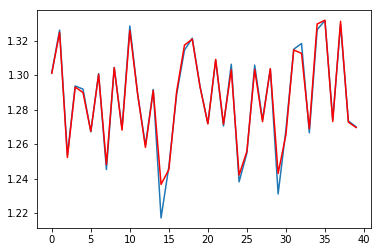

In [27]:
# Deep learning ANN 

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler

X = sntmnt_rates_df.iloc[:, 1:4].values
y = sntmnt_rates_df.iloc[:, 0].values
y=np.reshape(y, (-1,1))
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_X.fit(X))
xscale=scaler_X.transform(X)
print(scaler_y.fit(y))
yscale=scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

model = Sequential()
model.add(Dense(12, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='mae', optimizer='adam', metrics=['mse','mae','mape'])

history = model.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.3)


#Xnew= scaler_X.transform(X_test)
ynew= model.predict(X_test)
#invert normalize
ynew = scaler_y.inverse_transform(ynew) 
ytest = scaler_y.inverse_transform(y_test)
# plot
pyplot.plot(ytest)
pyplot.plot(ynew, color='red')
pyplot.show()
